In [80]:
import sys
sys.path.append('/workspaces/bha2/src')

In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from connectivity_functions import *
from tree_functions import *
from ni_functions import *
from io_functions import load_data, load_receptor_data
import os
import json
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list

In [83]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [84]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc"))
    fc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc"))
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [85]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm_nonzero.flatten()))
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_fc, fcm_thr, scm_nonzero)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0) 

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [86]:
g=0.8
opt_level=47

In [90]:
tree = json.loads(open(os.path.join(project_path, "data", "results", "n" + str(conn_size),
        "tree_equaldensity_bin_full_g_" + str(g) + ".json")).read())
level, labels = level_from_tree(tree, opt_level)
T = T_from_level(level).astype(int)
sim = similarity_level(fcm_bin, scm_bin, level)
mod_sc_lvl = modularity(scm_nonzero, T)
mod_fc_lvl = modularity(fcm_nonzero, T)
sc_intramod = []
fc_intramod = []
mod_size = []
xmod = []
idx = 0
for mod in level:
    if len(mod) > 1:
        sc_intramod.append(intramodular_modularity(scm_bin, mod))
        fc_intramod.append(intramodular_modularity(fcm_bin, mod))
        mod_size.append(len(mod))
        xmod.append(pow((sim[idx] * sc_intramod[idx] * fc_intramod[idx]), (1 / 3)))
        idx += 1




In [57]:
#get the position of mod_size equal to 1
single_roi_modules = np.where(np.array(mod_size) == 1)[0]
mod_size = np.delete(mod_size, single_roi_modules)
sc_intramod = np.delete(sc_intramod, single_roi_modules)
fc_intramod = np.delete(fc_intramod, single_roi_modules)
xmod = np.delete(xmod, single_roi_modules)

Text(0.5, 1.0, 'xmod vs module size')

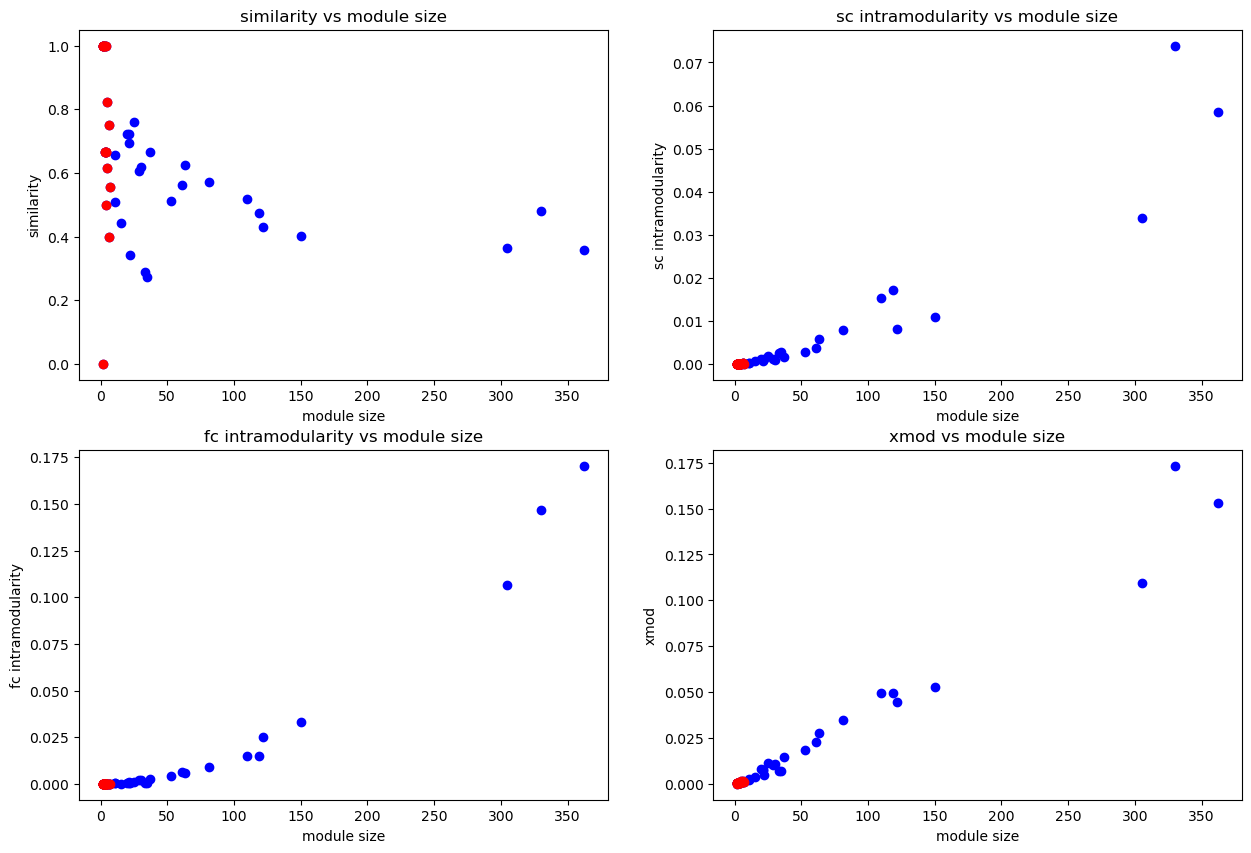

In [88]:
# represent in a three-panel subplot the scatters between sim and mod_size, sc_intramod and mod_size, fc_intramod and mod_size, xmod and mod_size
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].scatter(mod_size, sim, c='b', marker="o")
axs[0, 0].scatter(np.array(mod_size)[np.array(mod_size)<=10], np.array(sim)[np.array(mod_size)<=10], color='r')
axs[0, 0].set_xlabel('module size')
axs[0, 0].set_ylabel('similarity')
axs[0, 0].set_title('similarity vs module size')
axs[0, 1].scatter(mod_size, sc_intramod, c='b', marker="o")
axs[0, 1].scatter(np.array(mod_size)[np.array(mod_size)<=10], np.array(sc_intramod)[np.array(mod_size)<=10], color='r')
axs[0, 1].set_xlabel('module size')
axs[0, 1].set_ylabel('sc intramodularity')
axs[0, 1].set_title('sc intramodularity vs module size')
axs[1, 0].scatter(mod_size, fc_intramod, c='b', marker="o")
axs[1, 0].scatter(np.array(mod_size)[np.array(mod_size)<=10], np.array(fc_intramod)[np.array(mod_size)<=10], color='r')
axs[1, 0].set_xlabel('module size')
axs[1, 0].set_ylabel('fc intramodularity')
axs[1, 0].set_title('fc intramodularity vs module size')
axs[1, 1].scatter(mod_size, xmod, c='b', marker="o")
axs[1, 1].scatter(np.array(mod_size)[np.array(mod_size)<=10], np.array(xmod)[np.array(mod_size)<=10], color='r')
axs[1, 1].set_xlabel('module size')
axs[1, 1].set_ylabel('xmod')
axs[1, 1].set_title('xmod vs module size')



